# Functional enrichment of biological terms

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by assigning them to biological terms from prior knowledge.

In this notebook we showcase how to use `decoupler` for functional enrichment with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

scRNA-seqでは、それだけでは解釈が難しい多くの分子リードアウトが得られる。この情報を要約する1つの方法は、事前知識から生物学的用語に割り当てることである。

このノートブックでは、3k PBMC 10Xデータセットを用いて、機能濃縮にdecouplerを使用する方法を紹介します。このデータは、健康なドナーから得られた3k PBMCで構成されており、10x Genomics社からこのウェブページから自由に入手できます。

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

まず、関連するパッケージ、scRNA-seqデータを扱うscanpyと統計的手法を使うdecouplerをロードする必要がある。

In [1]:
import numpy as np

In [2]:
import scanpy as sc

In [3]:
# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [4]:
import decoupler as dc

## Loading the data

We can download the data easily using `scanpy`:

データはscanpyを使って簡単にダウンロードできる：

In [5]:
adata = sc.datasets.pbmc3k_processed()

In [6]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

私たちはその中で、さまざまな種類の細胞を可視化することができる：

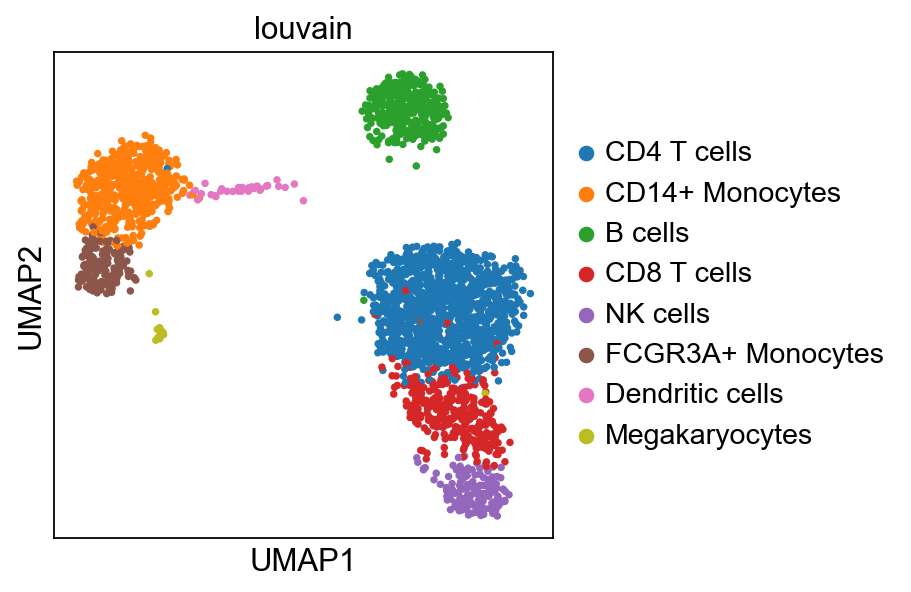

In [7]:
sc.pl.umap(adata, color='louvain')

## MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

Molecular Signatures Database (MSigDB)は、様々な生物学的プロセスにアノテーションされた遺伝子セットのコレクションを含むリソースである。

In [8]:
msigdb = dc.get_resource('MSigDB')

0.00B [00:00, ?B/s]

In [9]:
msigdb.head()

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP


As an example, we will use the hallmark gene sets, but we could have used any other such as KEGG or REACTOME.

We can filter by for `hallmark`:

例として、hallmark 遺伝子セットを使用するが、KEGG や REACTOME など他のものでもよい。

hallmarkでフィルタリングできる：

In [10]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection'] == 'hallmark']

In [11]:
# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

In [12]:
msigdb.head()

,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT


For this example we will use the resource MSigDB, but we could have used any other such as GO. To see the list of available resources inside `Omnipath`, run `dc.show_resources()`

この例では、リソースMSigDBを使用しますが、GOなど他のリソースを使用することもできます。Omnipath 内で利用可能なリソースのリストを見るには、dc.show_resources() を実行します。

## Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.
     
We can run `ora` with a simple one-liner:

機能的濃縮スコアを推測するために、Over Representation Analysis (ora)メソッドを実行する。入力データとして、発現行列(decoupler.run_ora)または差分発現解析結果(decoupler.run_ora_df)を受け取る。前者では、デフォルトでサンプルごとの発現遺伝子の上位5％が注目セット（S*）として選択され、後者ではユーザー定義の有意性フィルタリングを使用できる。S*が得られたら、使用する遺伝子セットリソース（net）に格納されている各セットについて、セット操作を使用して分割表を作成する。分割表を用いて、oraはセット間の重複の有意性を検定するために片側フィッシャー正確検定を実行する。最終的なスコアは得られたp値を対数変換することで得られ、値が大きいほど有意であることを意味する。

oraは簡単なワンライナーで実行できる：

In [13]:
dc.run_ora(
    mat=adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True
)

1 features of mat are empty, they will be removed.
Running ora on mat with 2638 samples and 13713 targets for 50 sources.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2638/2638 [00:02<00:00, 956.54it/s]


The obtained scores (-log10(p-value))(`ora_estimate`) and p-values (`ora_pvals`) are stored in the `.obsm` key:

得られたスコア(-log10(p-value))(ora_estimate)とp値(ora_pvals)は.obsmキーに格納される：

In [14]:
adata.obsm['ora_estimate'].head()

source,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
AAACATACAACCAC-1,1.307006,10.029702,0.822139,0.389675,1.670031,0.650245,2.441094,0.337563,0.805206,0.032740,...,0.733962,2.286568,0.354931,2.986336,8.270970,6.424740,0.586324,1.983873,0.164805,0.080157
AAACATTGAGCTAC-1,1.307006,14.824231,2.152116,0.389675,2.104104,-0.000000,0.442704,0.337563,0.457516,0.321093,...,2.496213,1.659624,1.015676,1.659624,3.053600,2.578916,0.346751,0.871448,0.503794,0.080157
AAACATTGATCAGC-1,3.893118,7.893567,3.312021,0.389675,3.095283,0.650245,5.115631,0.976973,0.805206,0.321093,...,1.087271,3.752012,0.037885,1.114303,7.597478,2.075696,0.888675,4.038435,0.164805,1.087420
AAACCGTGCTTCCG-1,5.591584,7.893567,2.152116,1.036748,1.670031,-0.000000,2.911700,0.143019,1.747025,0.591452,...,1.501986,3.752012,0.354931,1.659624,5.709134,5.000056,0.346751,1.567924,0.164805,1.087420
AAACCGTGTATGCG-1,0.999733,10.029702,2.707608,1.871866,1.670031,1.948869,0.666121,0.337563,0.805206,0.591452,...,1.973108,1.659624,0.151790,1.114303,1.803915,1.212284,0.586324,0.375221,0.164805,0.179270


## Visualization

To visualize the obtianed scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

表示されたスコアを視覚化するために、scanpyのプロット関数の多くを再利用することができます。しかし、最初にadataオブジェクトからスコアを抽出する必要があります。

In [15]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

In [16]:
acts

AnnData object with n_obs × n_vars = 2638 × 50
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ora_estimate', 'ora_pvals'

In [17]:
# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()

In [18]:
acts_v

array([ 1.3070061 , 10.029702  ,  0.82213867, ...,  4.038435  ,
        0.16480485,  0.08015702], dtype=float32)

In [19]:
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])

In [20]:
max_e

66.638596

In [21]:
acts.X[~np.isfinite(acts.X)] = max_e

In [22]:
acts

AnnData object with n_obs × n_vars = 2638 × 50
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ora_estimate', 'ora_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

dc.get_actsは、取得したアクティビティを.X属性に保持する新しいAnnDataオブジェクトを返すので、例えば、多くのscanpy関数を再利用することができます：

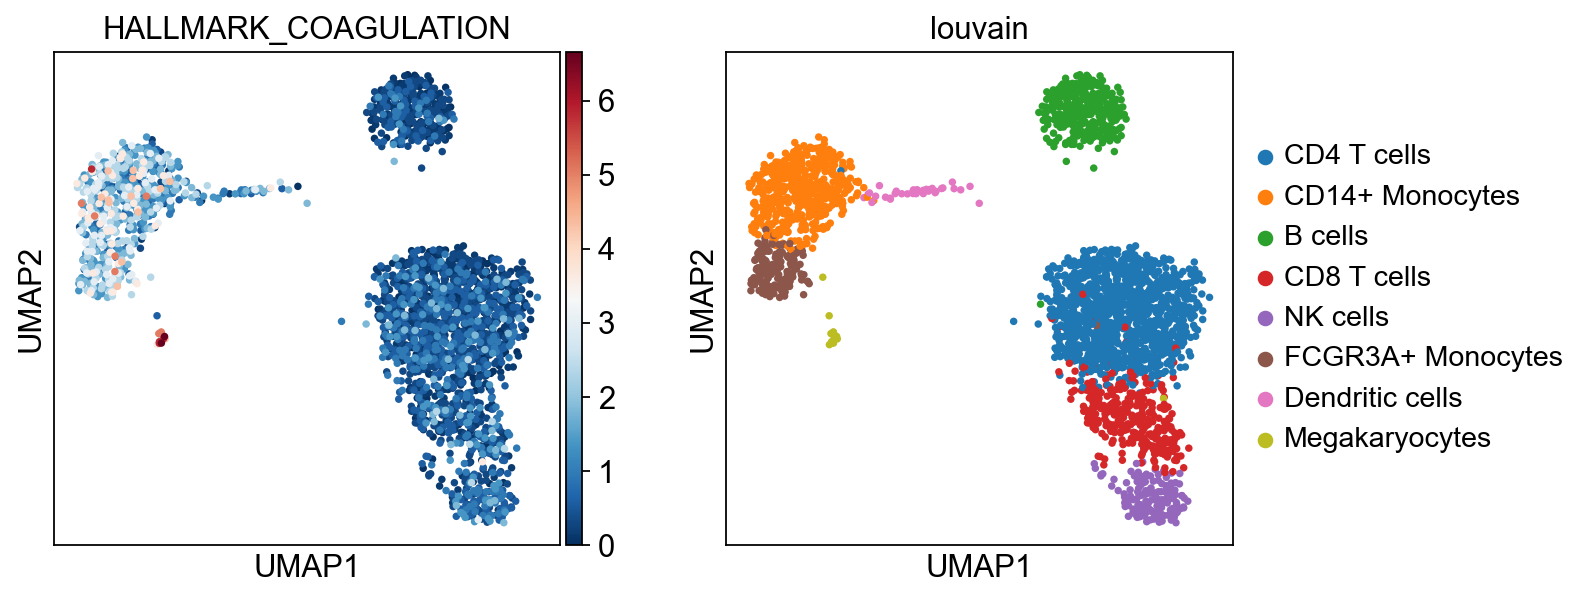

In [23]:
sc.pl.umap(acts, color=['HALLMARK_COAGULATION', 'louvain'], cmap='RdBu_r')

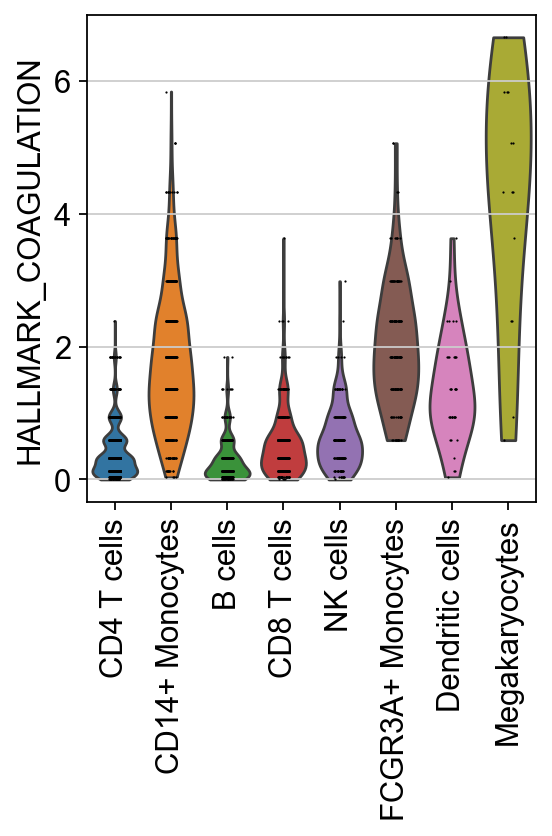

In [24]:
sc.pl.violin(acts, keys=['HALLMARK_COAGULATION'], groupby='louvain', rotation=90)

The cells highlighted seem to be enriched by coagulation.

強調された細胞は凝固によって濃縮されたようだ。

## Exploration

Let's identify which are the top gene sets per cell type. We can do it by using the function `dc.rank_sources_groups`, which identifies marker gene sets using the same statistical tests available in scanpy's `scanpy.tl.rank_genes_groups`.

細胞の種類ごとに、どの遺伝子セットが上位に来るかを見てみよう。これはscanpyのscanpy.tl.rank_genes_groupsで利用できるのと同じ統計的検定を使ってマーカー遺伝子セットを特定する。

In [25]:
df = dc.rank_sources_groups(
    acts, groupby='louvain',
    reference='rest', method='t-test_overestim_var'
)

In [26]:
df.head()

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cells,rest,HALLMARK_KRAS_SIGNALING_DN,8.300668,0.171902,6.620000e-16,3.009091e-15
1,B cells,rest,HALLMARK_HEDGEHOG_SIGNALING,2.108226,0.027850,3.538195e-02,5.528430e-02
2,B cells,rest,HALLMARK_MYOGENESIS,1.896726,0.074938,5.829358e-02,8.327655e-02
3,B cells,rest,HALLMARK_ALLOGRAFT_REJECTION,0.968864,0.204067,3.329577e-01,4.161971e-01
4,B cells,rest,HALLMARK_SPERMATOGENESIS,0.521071,0.009809,6.024869e-01,6.846442e-01


We can then extract the top 3 markers per cell type:

そして、細胞タイプごとに上位3つのマーカーを抽出することができる：

In [27]:
n_markers = 3

source_markers = (
    df
    .groupby('group')
    .head(n_markers)
    .groupby('group')['names']
    .apply(lambda x: list(x))
    .to_dict()
)

In [28]:
source_markers

{'B cells': ['HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_HEDGEHOG_SIGNALING',
  'HALLMARK_MYOGENESIS'],
 'CD14+ Monocytes': ['HALLMARK_COMPLEMENT',
  'HALLMARK_COAGULATION',
  'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'],
 'CD4 T cells': ['HALLMARK_WNT_BETA_CATENIN_SIGNALING',
  'HALLMARK_MYC_TARGETS_V1',
  'HALLMARK_MYC_TARGETS_V2'],
 'CD8 T cells': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_MYC_TARGETS_V2',
  'HALLMARK_PI3K_AKT_MTOR_SIGNALING'],
 'Dendritic cells': ['HALLMARK_OXIDATIVE_PHOSPHORYLATION',
  'HALLMARK_MYC_TARGETS_V1',
  'HALLMARK_ALLOGRAFT_REJECTION'],
 'FCGR3A+ Monocytes': ['HALLMARK_COMPLEMENT',
  'HALLMARK_COAGULATION',
  'HALLMARK_INTERFERON_GAMMA_RESPONSE'],
 'Megakaryocytes': ['HALLMARK_COAGULATION',
  'HALLMARK_ANGIOGENESIS',
  'HALLMARK_MYOGENESIS'],
 'NK cells': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_INTERFERON_GAMMA_RESPONSE',
  'HALLMARK_INTERFERON_ALPHA_RESPONSE']}

We can plot the obtained markers:

得られたマーカーをプロットすることができる：

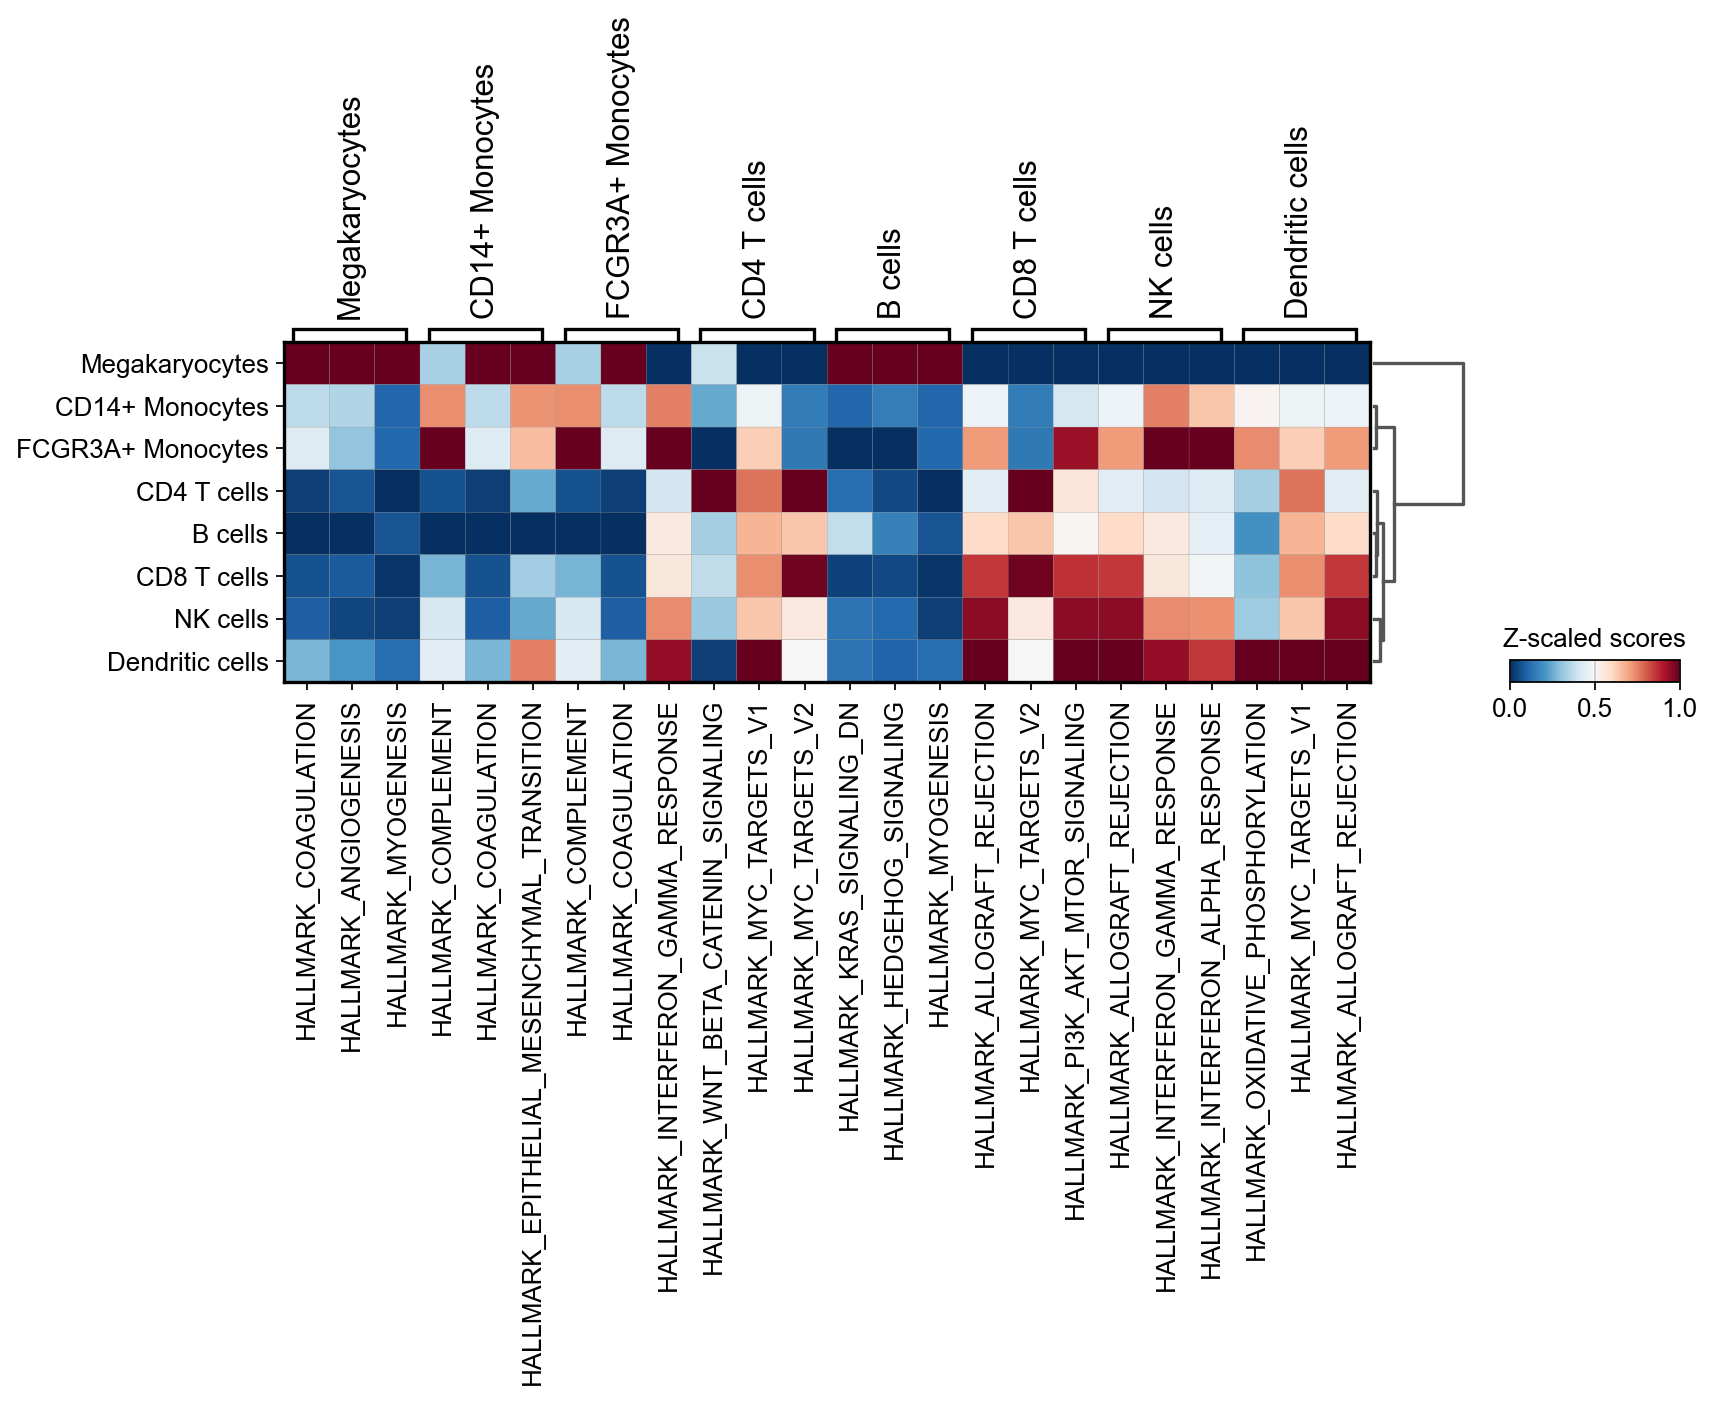

In [29]:
sc.pl.matrixplot(
    acts, source_markers, 'louvain',
    dendrogram=True, standard_scale='var',
    colorbar_title='Z-scaled scores', cmap='RdBu_r'
)

In this specific example, we can observe that myeloid cell types are enriched by the complement's system genes and megakaryocytes are enriched by coagulation genes.

この具体例では、骨髄系細胞は補体系の遺伝子によって濃縮され、巨核球は凝固遺伝子によって濃縮されていることが観察できる。